In [7]:
import os
import ipywidgets as widgets

from bqplot import *
import numpy as np
import pandas as pd
import qgrid

In [62]:
# Load your data into a DataFrame
df_home = pd.read_csv('data/tracking_home.csv')
df_away = pd.read_csv('data/tracking_away.csv')

# Identify the columns related to home players' x and y positions
home_x_columns = [col for col in df_home.columns if 'home' in col.lower() and 'x' in col.lower()]
home_y_columns = [col for col in df_home.columns if 'home' in col.lower() and 'y' in col.lower()]

# Identify the columns related to away players' x and y positions
away_x_columns = [col for col in df_away.columns if 'away' in col.lower() and 'x' in col.lower()]
away_y_columns = [col for col in df_away.columns if 'away' in col.lower() and 'y' in col.lower()]

# Identify the columns for ball position
ball_x_column = [col for col in df_home.columns if 'ball_x' in col.lower()][0]
ball_y_column = [col for col in df_home.columns if 'ball_y' in col.lower()][0]


In [63]:
def get_frameset(frameid):
    # Convert to native float type to avoid dtype issues
    home_x = df_home.loc[frameid, home_x_columns].dropna().astype(float).values
    home_y = df_home.loc[frameid, home_y_columns].dropna().astype(float).values
    home_names = [col.split('_')[1] for col in home_x_columns if not pd.isna(df_home.loc[frameid, col])]
    
    away_x = df_away.loc[frameid, away_x_columns].dropna().astype(float).values
    away_y = df_away.loc[frameid, away_y_columns].dropna().astype(float).values
    away_names = [col.split('_')[1] for col in away_x_columns if not pd.isna(df_away.loc[frameid, col])]
    
    ball_x = float(df_home.loc[frameid, ball_x_column])  # Ensure ball_x is float
    ball_y = float(df_home.loc[frameid, ball_y_column])  # Ensure ball_y is float

    return {
        'home_x': home_x,
        'home_y': home_y,
        'home_names': home_names,
        'home_color': ['blue'] * len(home_x),  # Assuming home players are blue
        'ball_x': [ball_x],
        'ball_y': [ball_y],
        'ball_color': ['black'],  # Ball color
        'away_x': away_x,
        'away_y': away_y,
        'away_names': away_names,
        'away_color': ['red'] * len(away_x),  # Assuming away players are red
    }


In [64]:
print(f"Length of df_home: {len(df_home)}, Length of df_away: {len(df_away)}")
print(f"Trying to access frameid: {frameid}")
test_frame = get_frameset(1)
print(test_frame)


Length of df_home: 144479, Length of df_away: 144479
Trying to access frameid: 0
{'home_x': array([ -0.48, -16.25, -17.23, -19.68,  -8.44, -46.54,   0.56,  -7.74,
        -9.77,  -2.08,  -0.33]), 'home_y': array([ 22.55, -11.07,  18.67,   0.84,   3.56,   0.18,   0.34, -22.99,
        -3.  ,  -9.43,  -1.14]), 'home_names': ['2', '3', '4', '8', '9', '13', '19', '21', '23', '24', '25'], 'home_color': ['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'], 'ball_x': [-0.1099999999999994], 'ball_y': [1.1499999999999986], 'ball_color': ['black'], 'away_x': array([5.260e+01, 1.011e+01, 1.507e+01, 8.210e+00, 3.000e-02, 3.100e-01,
       1.550e+01, 1.456e+01, 3.920e+00, 5.650e+00, 7.470e+00]), 'away_y': array([ 5.260e+01, -3.000e-01,  1.011e+01,  2.600e-01,  1.507e+01,
       -8.100e+00,  8.210e+00, -2.449e+01,  3.000e-02, -9.130e+00,
        3.100e-01,  8.980e+00,  1.550e+01,  1.501e+01,  1.456e+01,
        2.970e+00,  3.920e+00,  2.138e+01,  5.650e+00,  7.590

In [65]:
# Define pitch dimensions (use the actual size of the pitch used by SkillCorner)
PITCH_LENGTH = 105.0  # The length of the pitch in meters
PITCH_WIDTH = 68.0    # The width of the pitch in meters

# Set the coordinates to match the skillcorner pitch system
X = [-PITCH_LENGTH/2, PITCH_LENGTH/2]
Y = [-PITCH_WIDTH/2, PITCH_WIDTH/2]

# Optional: If you need to reverse the y-axis for visualization
Y_rev = [PITCH_WIDTH/2, -PITCH_WIDTH/2]

# Visualization adjustments for display in Voila (you may modify as necessary)
WIDTH = 506.7
HEIGHT = 346.7
FACTOR = 1.8




class RadarViewWidget(widgets.VBox):
    def __init__(self, pitch_img='pitch.png', enable_logging=True):
        super().__init__()
        self.pitch_img = pitch_img
        self.enable_logging = enable_logging
        self.image = self.__init_image()
        self.home_scatter = self.__init_scatter()
        self.away_scatter = self.__init_scatter()
        self.ball_scatter = self.__init_scatter(size=64, selected_opacity=1.0)
        
        self.fig = Figure(marks=[self.image, self.home_scatter, self.away_scatter, self.ball_scatter], padding_x=0, padding_y=0)
        self.fig.layout = widgets.Layout(width=f'{WIDTH*FACTOR}px', height=f'{HEIGHT*FACTOR}px')
        self.output = widgets.Output()
        
        self.children = [self.fig, self.output]
        
    def __init_image(self):
        # Read pitch image
        image_path = os.path.abspath(self.pitch_img)

        with open(image_path, 'rb') as f:
            raw_image = f.read()
        ipyimage = widgets.Image(value=raw_image, format='png')

        scales_image = {'x': LinearScale(min=X[0], max=X[1]), 'y': LinearScale(min=Y_rev[0], max=Y_rev[1])}
        axes_options = {'x': {'visible': True}, 'y': {'visible': True}}

        image = Image(image=ipyimage, scales=scales_image, axes_options=axes_options)
        # Full screen
        image.x = X
        image.y = Y_rev
        
        return image
        
    def __init_scatter(self, size=128, selected_opacity=0.6, unselected_opacity=1.0):
        scales = {'x': LinearScale(min=X[0], max=X[1]), 'y': LinearScale(min=Y_rev[0], max=Y_rev[1])}
        axes_options = {'x': {'visible': False}, 'y': {'visible': False}}

        scatter = Scatter(
                            scales=scales, 
                            default_size=size,
                            interactions={'click': 'select'},
                            selected_style={'opacity': selected_opacity, 'stroke': 'Black'},
                            unselected_style={'opacity': unselected_opacity},
                            axes_options=axes_options)
        scatter.enable_move = True
        
        if self.enable_logging:
            scatter.on_drag_end(self.output_data)
        
        return scatter

    
    def disable_move(self):
        self.home_scatter.enable_move = False
        self.away_scatter.enable_move = False
        self.ball_scatter.enable_move = False

    def output_data(self, name, data):
        new_x = round(data['point']['x'], 2)
        new_y = round(data['point']['y'], 2)
        
        self.output.clear_output()
        with self.output:
            print(f'Changed player coordinates to ({new_x},{new_y})')
    
    def set_data(self, frameset):
        self.home_scatter.x = frameset['home_x']
        self.home_scatter.y = frameset['home_y']
        self.home_scatter.names=frameset['home_names'],
        self.home_scatter.colors=frameset['home_color']
        
        self.away_scatter.x = frameset['away_x']
        self.away_scatter.y = frameset['away_y']
        self.away_scatter.names=frameset['away_names'],
        self.away_scatter.colors=frameset['away_color']
        
        self.ball_scatter.x = frameset['ball_x']
        self.ball_scatter.y = frameset['ball_y']
        self.ball_scatter.colors = frameset['ball_color']
        


In [66]:
widget = RadarViewWidget()
display(widget)

frameid = 0
initial_frameset = get_frameset(frameid)
widget.set_data(initial_frameset)



RadarViewWidget(children=(Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(…

In [67]:
frameid = 0  # Start with the first frame
initial_frameset = get_frameset(frameid)

widget.set_data(initial_frameset)


widget.disable_move()

# Speedup animation
STEP = 2

play = widgets.Play(
    value=0,
    step=STEP,
    max=len(df_home),
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider(max=len(df_home))
widgets.jslink((play, 'value'), (slider, 'value'))

def change_data(change):
    widget.set_data(get_frameset(change['new']))

slider.observe(change_data, names='value')

# Display the widget and controls
display(widget)
widgets.HBox([play, slider])



RadarViewWidget(children=(Figure(fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(…

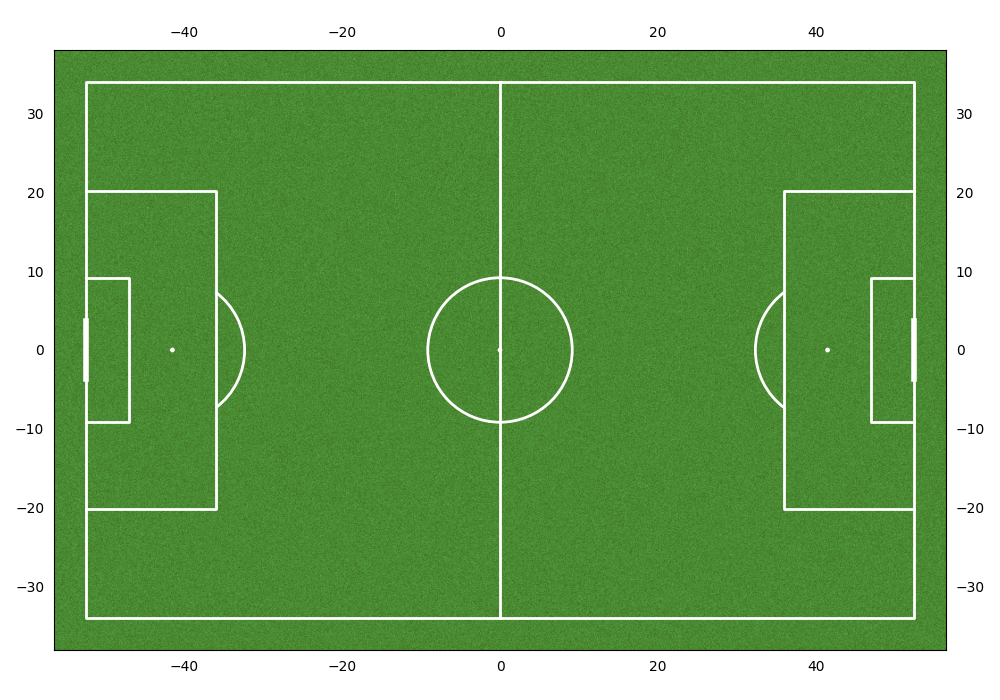

In [3]:
import matplotlib.pyplot as plt
from mplsoccer import *

%matplotlib widget
# Initialize plot
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))


# List to store points
points = []

# Function to handle mouse clicks
def on_click(event):
    if event.inaxes:  # Check if click is inside plot
        x, y = event.xdata, event.ydata  # Get coordinates
        points.append((x, y))  # Add to list of points
        ax.plot(x, y, 'ro')  # Plot the point
        plt.draw()  # Redraw the figure



# Connect the click event to the handler
fig.canvas.mpl_connect('button_press_event', on_click)


plt.show()


In [18]:
from libs.feature_generation import *
# Click player into the pitch and take those player and apply Ripleys K to them. And then maybe PCA


In [19]:
# Flatten the points list [(x1, y1), (x2, y2), ...] into a single series [x1, y1, x2, y2, ...]
points_series = pd.Series(np.array(points).flatten())

# Define the radii for which to calculate Ripley's K
radii = np.linspace(0, 34, 100)  # Example: 100 radii values from 0 to 34 meters

# Apply Ripley's K function on the clicked points
k_values = ripley_k(points_series, radii, width=105.0, height=68.0)


In [21]:
points

[(np.float64(9.797931818464889), np.float64(-28.295710594906254)),
 (np.float64(-16.301731816766207), np.float64(-15.752668362440826)),
 (np.float64(-8.953282832089492), np.float64(-28.80250018005637)),
 (np.float64(18.540052162304434), np.float64(-5.870271452013519)),
 (np.float64(-37.33349960049612), np.float64(29.604999508494757)),
 (np.float64(-0.08446509196242147), np.float64(-19.046800665916596)),
 (np.float64(-4.772268754601015), np.float64(-15.879365758728355)),
 (np.float64(8.27756306301454), np.float64(-21.834143384242246))]

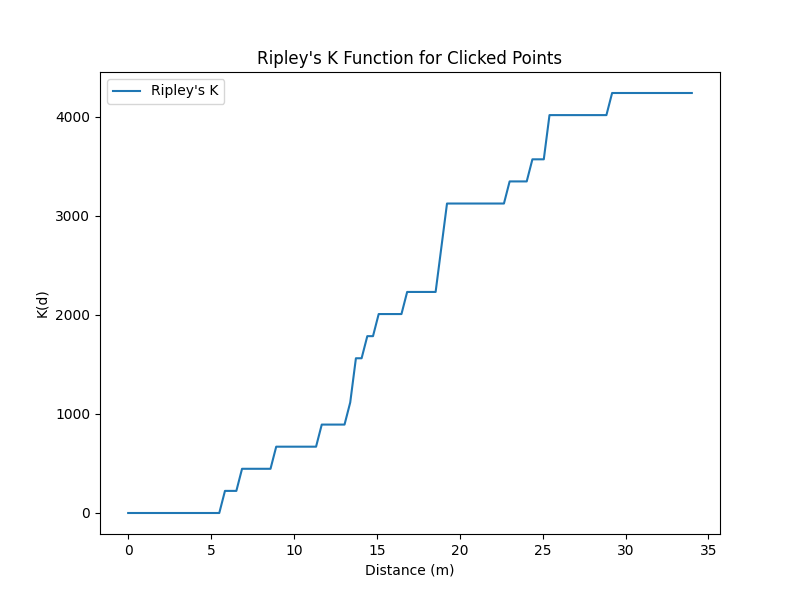

In [22]:
import matplotlib.pyplot as plt

# Plot the results of Ripley's K
plt.figure(figsize=(8, 6))
plt.plot(radii, k_values, label="Ripley's K")
plt.xlabel('Distance (m)')
plt.ylabel("K(d)")
plt.title("Ripley's K Function for Clicked Points")
plt.legend()
plt.show()
